In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [9]:
def load_image(path):
    transform = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor()
    ])
    image = Image.open(path).convert('RGB')
    return transform(image)

def show(img, title=""):
    npimg = img.permute(1, 2, 0).numpy()
    plt.imshow(np.clip(npimg, 0, 1))
    plt.title(title)
    plt.axis('off')
    plt.show()

def cutout(img, size=32):
    img = img.clone()
    h, w = img.shape[1], img.shape[2]
    y = random.randint(size//2, h - size//2)
    x = random.randint(size//2, w - size//2)
    img[:, y-size//2:y+size//2, x-size//2:x+size//2] = 0
    return img

def mixup(img1, img2, label1, label2, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    mixed_img = lam * img1 + (1 - lam) * img2
    return mixed_img, lam, label1, label2

def cutmix(img1, img2, label1, label2):
    img = img1.clone()
    h, w = img.shape[1], img.shape[2]
    cut_w, cut_h = w // 2, h // 2
    x = random.randint(0, w - cut_w)
    y = random.randint(0, h - cut_h)
    img[:, y:y+cut_h, x:x+cut_w] = img2[:, y:y+cut_h, x:x+cut_w]
    lam = 1 - (cut_w * cut_h / (h * w))
    return img, lam, label1, label2

In [ ]:
img_path1 = 'img1.png'
img_path2 = 'img2.png'


label1, label2 = 3,2 
img1 = load_image(img_path1)
img2 = load_image(img_path2)

In [ ]:
cutout_image = cutout(img_path1)
show(cutout_image, f'cutout-image {label1}')

mixup_img, lam, l1, l2 = mixup(img1, img2, label1, label2)
show(cutout_image, f'mixup lambda={lam}')

/var/folders/xr/vbwc0m5161765_40_dyj8snc0000gn/T/ipykernel_91316/1631977101.py:36: UserWarning: Argument(s) 'max_height, max_width, min_height, min_width' are not valid for transform CoarseDropout
  "CoarseDropout": A.CoarseDropout(max_height=40, max_width=40, min_height=20, min_width=20, p=1.0),


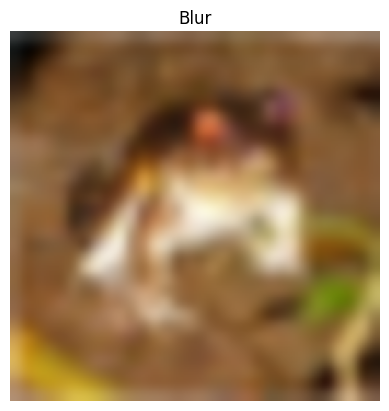

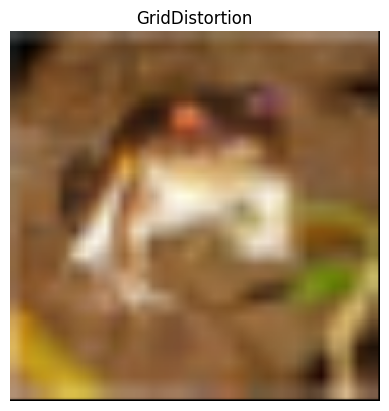

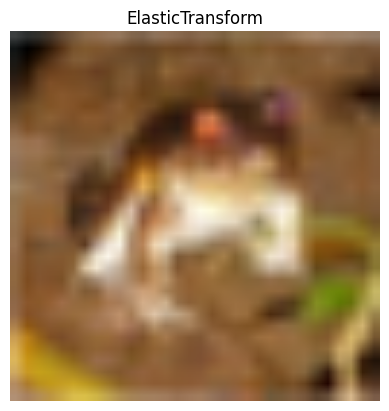

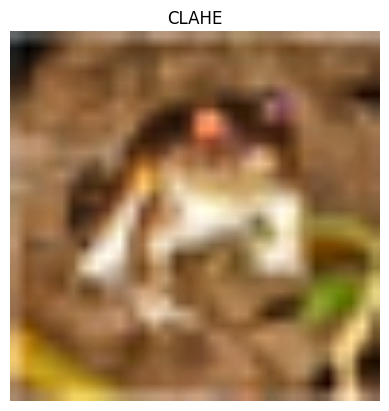

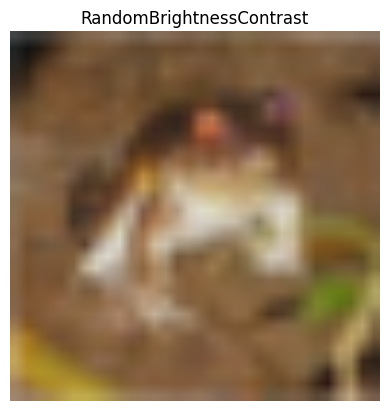

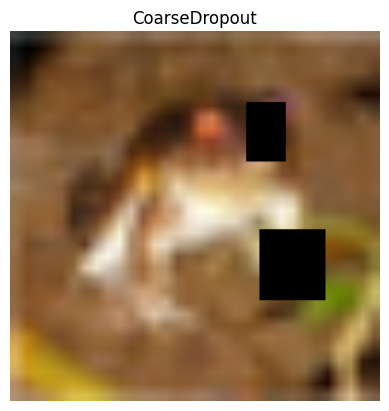

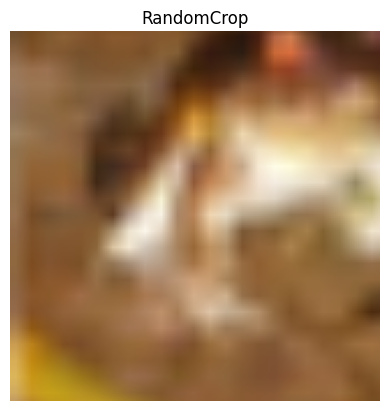

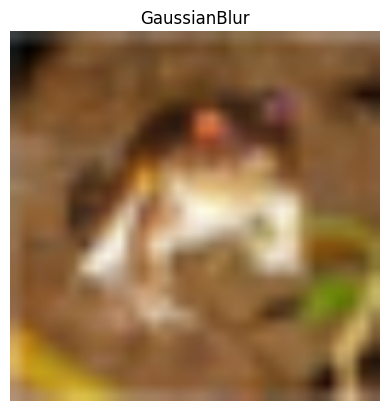

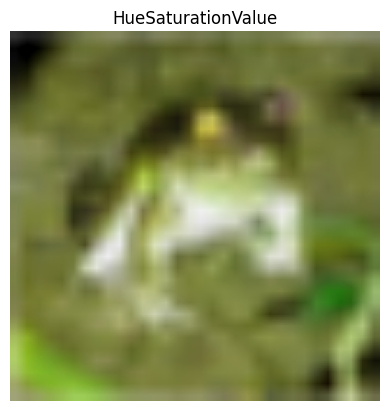

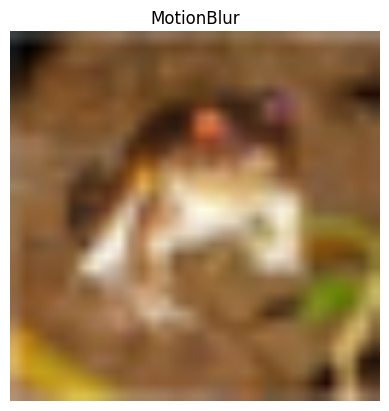

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Load one CIFAR-10 image for demonstration
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
img_tensor, label = dataset[0]
img = img_tensor.permute(1, 2, 0).numpy() * 255
img = img.astype(np.uint8)

# Resize for better visualization
img = cv2.resize(img, (224, 224))

# Utility to visualize augmentation
def show_augmented(title, aug_img):
    plt.imshow(aug_img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Albumentations: Advanced augmentations
augmentations = {
    "Blur": A.Blur(blur_limit=7, p=1.0),
    "GridDistortion": A.GridDistortion(p=1.0),
    "ElasticTransform": A.ElasticTransform(p=1.0),
    "CLAHE": A.CLAHE(p=1.0),
    "RandomBrightnessContrast": A.RandomBrightnessContrast(p=1.0),
    "CoarseDropout": A.CoarseDropout(max_height=40, max_width=40, min_height=20, min_width=20, p=1.0),
    "RandomCrop": A.RandomCrop(width=160, height=160, p=1.0),
    "GaussianBlur": A.GaussianBlur(blur_limit=(3, 7), p=1.0),
    "HueSaturationValue": A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0),
    "MotionBlur": A.MotionBlur(blur_limit=7, p=1.0)
}

# Visualize each Albumentations augmentation
for name, aug in augmentations.items():
    aug_img = aug(image=img)['image']
    show_augmented(name, aug_img)

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
model = YOLO("yolo11n-seg.pt")

In [ ]:
# Open webcam and make real-time predictions
cap = cv2.VideoCapture(0)  # Open the default webcam (use 0 for default, or change to the desired camera index)

if not cap.isOpened():
    print("Error: Could not open webcam.")
else:
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture frame.")
                break

            # Convert frame to RGB (YOLO model expects RGB images)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Perform prediction
            results = model.predict(source=rgb_frame, show=False, conf=0.5)

            # Visualize predictions on the frame
            annotated_frame = results[0].plot()

            # Display the frame with predictions
            cv2.imshow("YOLO Predictions", annotated_frame)

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()